# Computational Psycholinguistics - Assignment 2

## Imports

In [35]:
from get_predictions import get_predictions

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import scipy.io
import torch

## Setup

In [2]:
def set_global_seed(seed):
    """Sets the same seed for varying libraries."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

RAW_DATA_FILE_PATH = "./data/stimuli_erp.mat"
EXPERIMENTAL_STIMULI_FILE_PATH = "./items/stimuli.txt"

ITEM_SETS = ["stimuli"]
LANGUAGE = "en"
CUDA = True

set_global_seed(3131)

## Loading the Raw Data

In [3]:
dataset = scipy.io.loadmat(RAW_DATA_FILE_PATH)
sentences = dataset["sentences"]
erp_data = dataset["ERP"]

print(erp_data.shape) # NOTE: All ERP averages
print(erp_data[0].shape) # NOTE: All ERP averages for sentence 0 as one single tuple
print(erp_data[0][0].shape) # NOTE: All ERP averages for sentence 0 as a tuple of (words, participants, ERP components)
print(erp_data[0][0][0].shape) # NOTE: All ERP averages for word 0 of sentence 0
print(erp_data[0][0][0][0].shape) # NOTE: All ERP averages for participant 0 for word 0 of sentence 0
print(erp_data[0][0][0][0][4]) # NOTE: P600 ERP average for participant 0 for word 0 of sentence 0

(205, 1)
(1,)
(5, 24, 6)
(24, 6)
(6,)
-1.8152039051055908


## Parsing the Sentence Data and Generating the Plain Text Stimuli File

In [4]:
parsed_sentence_data = []

with open(EXPERIMENTAL_STIMULI_FILE_PATH, "w") as stimuli_file:
    for sentence in sentences:
        parsed_sentence = []
        sentence = sentence[0][0]
        
        for index, word in enumerate(sentence):
            word = str(word[0])
            
            parsed_sentence.append(word)
            
            word = word.lower()
            
            if "." in word:
                word = word.replace(".", " .")
                
            stimuli_file.write(word)
            
            if index == len(sentence) - 1:
                stimuli_file.write("\n")
            else:
                stimuli_file.write(" ")
                
        parsed_sentence_data.append(parsed_sentence)

## Parsing the P600 Data by Sentence

In [5]:
parsed_p600_data = []

for erp_sentence_data in erp_data:
    erp_sentence_data = erp_sentence_data[0]
    parsed_sentence_data = []
    
    for i in range(erp_sentence_data.shape[1]):
        participant_p600_for_sentence = [float(p600) for p600 in erp_sentence_data[:, i, 4]]
        parsed_sentence_data.append(participant_p600_for_sentence)
        
    parsed_p600_data.append(parsed_sentence_data)

## Generating the Model Surprisal Values

In [13]:
get_predictions(ITEM_SETS, LANGUAGE, "surp", CUDA)

model_stimuli_surprisal_df = pd.read_csv("./predictions/surp_stimuli.csv", sep="\t")
del model_stimuli_surprisal_df["Unnamed: 0"]

model_stimuli_surprisal_df

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,surp_30000000,surp_epoch1
0,1,1,101,6.836413,4.707911,3.947554,4.094619,4.726980,5.756513,6.399938,7.089447,6.435467
1,1,2,102,9.288938,8.235802,8.197250,7.507866,5.409412,6.177730,5.586932,5.922409,5.222564
2,1,3,103,9.142862,8.210672,8.031253,7.789608,4.846162,4.301919,3.926872,3.228703,4.466794
3,1,4,104,4.742215,4.672691,4.514076,4.958948,2.137337,0.943905,0.821426,0.915931,0.708956
4,1,5,105,5.913204,5.588213,5.787216,5.792560,6.385126,5.818783,5.915521,6.207226,6.074735
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,205,9,20509,9.468374,8.539412,8.570766,8.404335,7.364338,4.989576,3.788672,3.112464,3.001311
2132,205,10,20510,9.983400,9.125396,8.786782,8.881791,8.340035,7.244709,5.905184,6.397970,7.190235
2133,205,11,20511,6.348531,6.507536,6.513234,6.639857,4.121954,2.635970,2.201653,2.113567,1.915407
2134,205,12,20512,7.062437,7.243497,7.173066,7.001952,9.152929,5.869561,5.553642,5.024977,3.113113


## Generating the Model Gradients

In [14]:
get_predictions(ITEM_SETS, LANGUAGE, "grad", CUDA)

model_stimuli_gradient_df = pd.read_csv("./predictions/grad_stimuli.csv", sep="\t")
del model_stimuli_gradient_df["Unnamed: 0"]

model_stimuli_gradient_df

,sent_nr,word_pos,item,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1
0,1,1,101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,102,18.973602,29.303833,23.013428,50.111851,155.621353,356.073730,591.474792,950.615173,916.272278
2,1,3,103,48.192589,52.353775,47.574013,133.064423,447.145355,992.735474,1233.697754,1474.690552,1340.782104
3,1,4,104,152.071564,194.270233,217.592896,418.993561,1268.529053,1716.162598,2588.392090,2718.549805,2131.545166
4,1,5,105,155.604553,74.379417,101.549599,167.167297,966.557861,2630.439453,4642.015625,4349.675293,4239.321777
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,205,9,20509,162.758682,104.815720,118.573441,241.563873,1338.155518,3129.649902,3442.307373,4006.755371,4073.013672
2132,205,10,20510,201.055206,96.702126,119.630630,262.677063,2134.760742,3840.750000,4937.511230,6278.169922,5755.274414
2133,205,11,20511,165.124695,93.393753,238.789093,248.142410,2945.145996,3598.960449,3727.153564,2389.245605,2220.633057
2134,205,12,20512,175.054016,91.080688,179.269196,357.131104,2670.154053,2342.652588,3812.427734,4139.393066,3849.694092


## Visualizing Correlations between Data

In [95]:
def draw_lineplot(x_axis_name: str, y_axis_name: str, df: pd.DataFrame, x_axis_label: str = None, y_axis_label: str = None, title: str = None) -> pd.DataFrame:   
    # Draw a linear regression plot, a scatter plot with a linear regression line on top of it
    plt.figure()
    plot = sns.lmplot(x=x_axis_name, y=y_axis_name, data=df, seed=3131, line_kws={"color": "C1"})
    
    if (x_axis_label is not None) and (y_axis_label is not None):
        plot.set_axis_labels(x_axis_label, y_axis_label)
    
    if title is not None:
        plt.title(title)
    
    # Iterate over the data points in the plot
    for _, facet_df in plot.facet_data():
        # Remove missing values when calculating the linear regression
        facet_df = facet_df.dropna(axis=0)
        
        # Calculate slope, intercept, and correlation coefficient r of the linear regression shown in the plot
        reg_slope, reg_intercept, r, _, _ = scipy.stats.linregress(
            x=facet_df[x_axis_name],
            y=facet_df[y_axis_name]
        )
        
        print(len(facet_df))
        
        # Write the regression's formula onto the plot
        max_x = facet_df[x_axis_name].max(axis=0)
        max_y = facet_df[y_axis_name].max(axis=0)
        
        plt.text(max_x * 0.8, max_y * 0.95, f"y = {round(reg_slope, 2)}x + {round(reg_intercept)}")
        plt.text(max_x * 0.8, max_y * 0.90, f"r = {round(r, 3)}")
        
    return reg_slope, reg_intercept, r

# Merging the model stimuli dataframes
model_stimuli_df = pd.merge(model_stimuli_surprisal_df, model_stimuli_gradient_df.iloc[:, 2:], on="item")

# Removing sentence-initial word, sentence-final word, and period
model_stimuli_df = model_stimuli_df[~(model_stimuli_df["word_pos"].shift(-1) == 1)] # NOTE: Remove periods
model_stimuli_df = model_stimuli_df[~(model_stimuli_df["word_pos"].shift(-1) == 1)] # NOTE: Remove sentence-final words
model_stimuli_df = model_stimuli_df[~(model_stimuli_df["word_pos"] == 1)] # NOTE: Remove sentence-initial words
model_stimuli_df = model_stimuli_df.iloc[:-2, :] # NOTE: Remove period and sentence-final word of final sentence
model_stimuli_df

,sent_nr,word_pos,item,surp_10000,surp_30000,surp_100000,surp_300000,surp_1000000,surp_3000000,surp_10000000,...,surp_epoch1,grad_10000,grad_30000,grad_100000,grad_300000,grad_1000000,grad_3000000,grad_10000000,grad_30000000,grad_epoch1
1,1,2,102,9.288938,8.235802,8.197250,7.507866,5.409412,6.177730,5.586932,...,5.222564,18.973602,29.303833,23.013428,50.111851,155.621353,356.073730,591.474792,950.615173,916.272278
2,1,3,103,9.142862,8.210672,8.031253,7.789608,4.846162,4.301919,3.926872,...,4.466794,48.192589,52.353775,47.574013,133.064423,447.145355,992.735474,1233.697754,1474.690552,1340.782104
3,1,4,104,4.742215,4.672691,4.514076,4.958948,2.137337,0.943905,0.821426,...,0.708956,152.071564,194.270233,217.592896,418.993561,1268.529053,1716.162598,2588.392090,2718.549805,2131.545166
7,2,2,202,10.343987,10.772951,10.055124,9.783902,9.598692,8.130068,7.441774,...,8.497746,38.515953,44.912571,33.733639,37.512085,583.094421,1044.615845,1027.677734,1289.434814,1554.548340
8,2,3,203,3.655336,3.196918,3.985500,3.261256,2.296362,3.963031,3.440089,...,3.217976,151.006027,55.935799,86.899811,289.253418,2119.205811,2901.414551,3102.004639,2600.237549,2634.064697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,205,7,20507,5.250892,5.221284,4.964741,4.788162,4.264303,4.479417,5.589550,...,4.731210,172.044312,82.392807,109.042603,247.769608,2749.050293,3730.191406,3586.152344,3998.595215,3091.233643
2130,205,8,20508,6.366280,6.508044,6.487020,6.656782,4.828741,3.074005,2.855506,...,2.536750,154.294449,87.633179,177.768814,216.795181,2340.139160,3971.171143,4107.865723,2959.993408,2628.775635
2131,205,9,20509,9.468374,8.539412,8.570766,8.404335,7.364338,4.989576,3.788672,...,3.001311,162.758682,104.815720,118.573441,241.563873,1338.155518,3129.649902,3442.307373,4006.755371,4073.013672
2132,205,10,20510,9.983400,9.125396,8.786782,8.881791,8.340035,7.244709,5.905184,...,7.190235,201.055206,96.702126,119.630630,262.677063,2134.760742,3840.750000,4937.511230,6278.169922,5755.274414


### Visualizing Correlations between Model Surprisal and Model Gradients

1420
1420
1420
1420
1420
1420
1420
1420
1420


<Axes: xlabel='Model Size', ylabel='r'>

<Figure size 640x480 with 0 Axes>

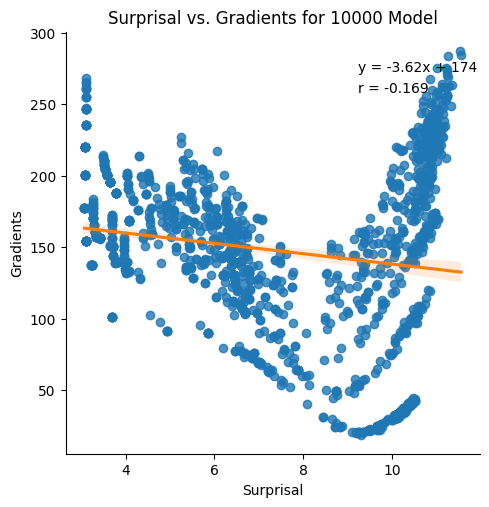

<Figure size 640x480 with 0 Axes>

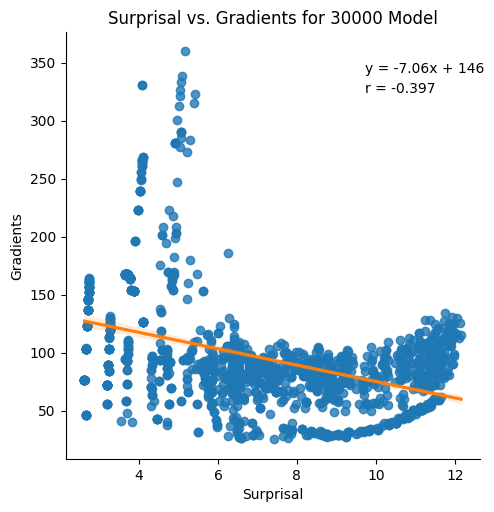

<Figure size 640x480 with 0 Axes>

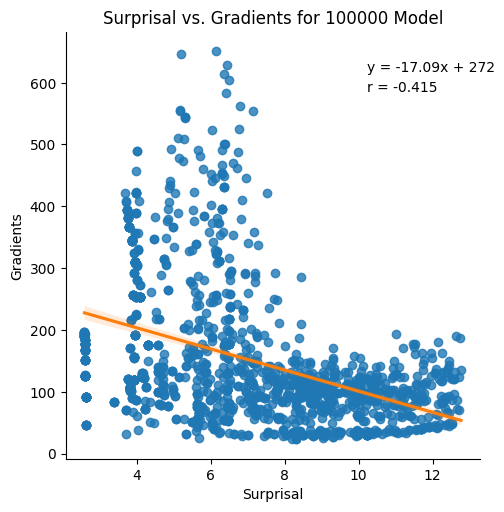

<Figure size 640x480 with 0 Axes>

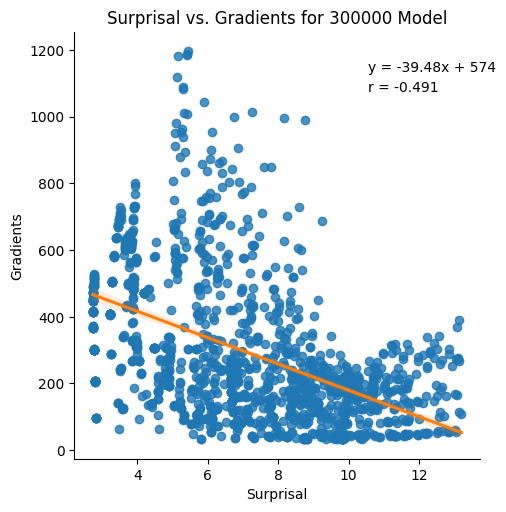

<Figure size 640x480 with 0 Axes>

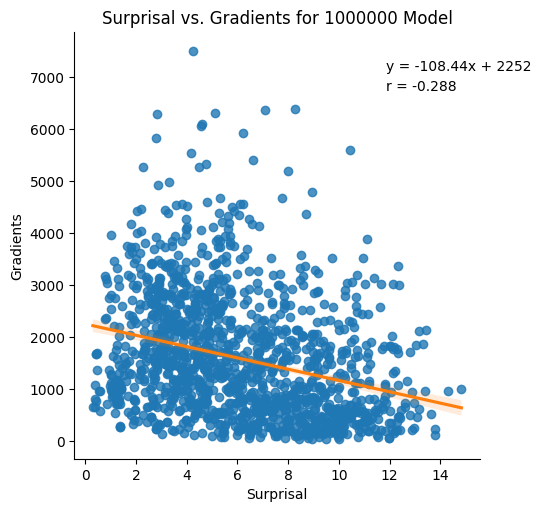

<Figure size 640x480 with 0 Axes>

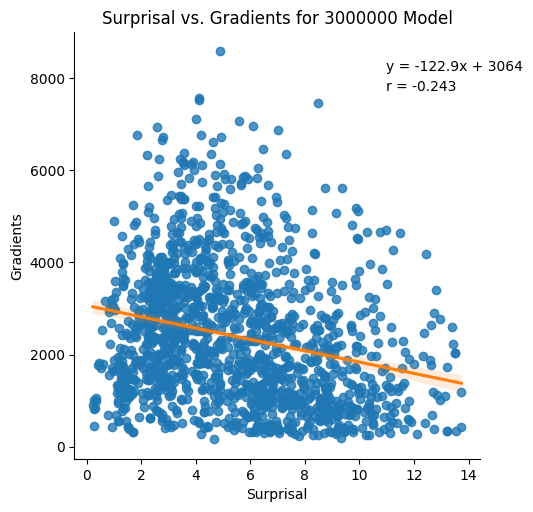

<Figure size 640x480 with 0 Axes>

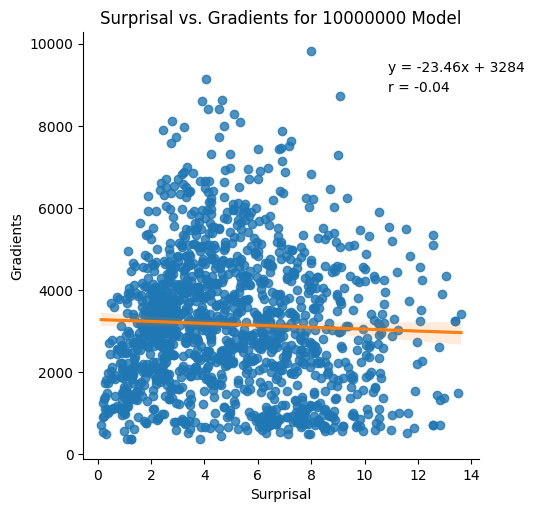

<Figure size 640x480 with 0 Axes>

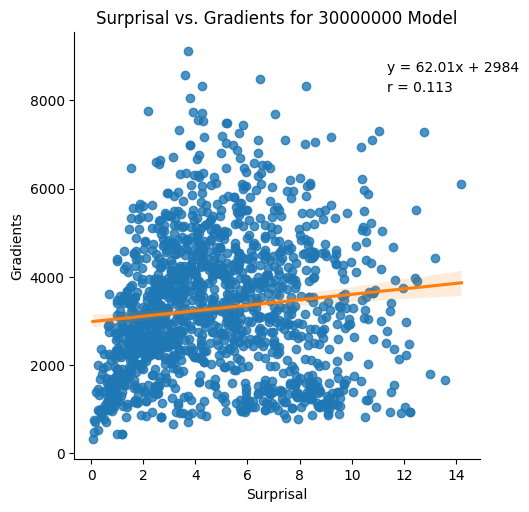

<Figure size 640x480 with 0 Axes>

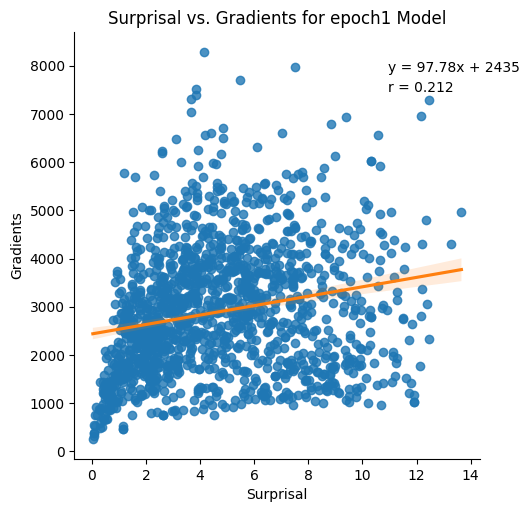

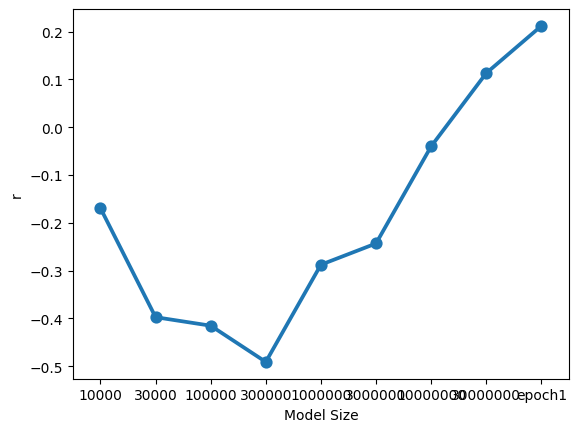

In [97]:
# Finding the columns with results of different model sizes
model_column_names_mask = model_stimuli_df.columns.str.contains("surp_*")
surpisal_columns_df = model_stimuli_df.loc[:, model_column_names_mask]

regression_data_df = []
# For every model size, visualize the correlation between its surprisal values and gradient values
for column_name in surpisal_columns_df.columns:
    model_size_string = column_name[5:]
    
    slope, intercept, r = draw_lineplot(
        x_axis_name=f"surp_{model_size_string}", 
        y_axis_name=f"grad_{model_size_string}", 
        df=model_stimuli_df,
        x_axis_label="Surprisal",
        y_axis_label="Gradients",
        title=f"Surprisal vs. Gradients for {model_size_string} Model"
    )
    
    regression_data_df.append([model_size_string, slope, intercept, r])
    
regression_data_df = pd.DataFrame(regression_data_df, columns=["Model Size", "Slope", "Intercept", "r"])

plt.figure()
sns.pointplot(data=regression_data_df, x="Model Size", y="r")